In [2]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Lambda, Flatten, Reshape, MaxPooling2D
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy, kullback_leibler_divergence
from keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
from sklearn.preprocessing import StandardScaler#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_to_df import *

Using TensorFlow backend.


In [3]:
#Get the data
df = csv_to_df('test/')
df = df.fillna(0)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [4]:
#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

In [5]:
#We have created a df of our values and some kind of class label
#We should normalize
x = df[variables].values
x_scaled = StandardScaler().fit_transform(x)
df[variables] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
						    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [6]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 4, 3, 5))
x_test = x_test.reshape((x_test.shape[0], 4, 3, 5))

In [7]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon

In [8]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (3, 3)
strides = (1, 1)


In [9]:
#Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same')(x_input)
pool_1 = MaxPooling2D(pool_size = (1, 1),
                      strides = 2,
                      data_format = 'channels_first')(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same')(pool_1)

#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)
#cnn = Model(x_input, flatten, name = 'cnn')
#cnn.summary()

shape = input_shape

In [10]:
#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                        activation = act_fun,
                        name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                        activation = act_fun,
                        name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 4, 3, 5)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 3, 32)     1472        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 4, 2, 16)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 2, 32)     4640        max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [11]:
#Decoding
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(shape[0]*shape[1]*shape[2], 
                        activation = act_fun, name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                           kernel_size = kernel_size, 
                           activation = act_fun, 
                           strides = strides, 
                           padding = 'same', 
                           name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 16,
                           kernel_size = kernel_size, 
                           activation = act_fun, 
                           strides = strides, 
                           padding = 'same', 
                           name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 5, 
                         kernel_size = kernel_size, 
                         activation = 'sigmoid', 
                         padding = 'same', 
                         strides = strides, 
                         name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 4)                 0         
_________________________________________________________________
dense_decoder_1 (Dense)      (None, 60)                300       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 3, 5)           0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 4, 3, 32)          1472      
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 4, 3, 16)          4624      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 4, 3, 5)           725       
Total params: 7,121
Trainable params: 7,121
Non-trainable params: 0
_________________________________________________________

In [12]:
#Build the VAE model
outputs = decoder(encoder(x_input)[2])
vae = Model(x_input, outputs, name = 'vae')

In [57]:
#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    recon_loss = K.mean(recon_loss)
    return recon_loss

def my_vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = recon + kl
    return vae_loss


In [59]:
vae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
vae.summary()


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 4, 3, 5)           0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 19914     
_________________________________________________________________
decoder (Model)              (None, 4, 3, 5)           7121      
Total params: 27,035
Trainable params: 27,035
Non-trainable params: 0
_________________________________________________________________


In [60]:
#Fit the model
epochs = 100
batch_size = 1000

history = vae.fit(x = x_train,
                  y = x_train,
                  validation_data = (x_train, x_train),
                  epochs = epochs,
                  batch_size = batch_size,
                  verbose = 2)

vae.save('cnn-vae_model.h5')

Train on 6075 samples, validate on 6075 samples
Epoch 1/100
 - 6s - loss: 56.5557 - kl_loss: 0.6183 - recon_loss: 52.3071 - val_loss: 56.2025 - val_kl_loss: 0.5428 - val_recon_loss: 51.4786
Epoch 2/100
 - 1s - loss: 56.1445 - kl_loss: 0.5745 - recon_loss: 50.9407 - val_loss: 56.1662 - val_kl_loss: 0.6207 - val_recon_loss: 51.3741
Epoch 3/100
 - 2s - loss: 56.1438 - kl_loss: 0.5945 - recon_loss: 51.2637 - val_loss: 56.1303 - val_kl_loss: 0.5964 - val_recon_loss: 51.3313
Epoch 4/100
 - 1s - loss: 56.1436 - kl_loss: 0.6347 - recon_loss: 52.7860 - val_loss: 56.1836 - val_kl_loss: 0.6258 - val_recon_loss: 51.3698
Epoch 5/100
 - 1s - loss: 56.1807 - kl_loss: 0.6224 - recon_loss: 51.8240 - val_loss: 56.2118 - val_kl_loss: 0.6657 - val_recon_loss: 51.3802
Epoch 6/100
 - 1s - loss: 56.1134 - kl_loss: 0.6308 - recon_loss: 53.4610 - val_loss: 56.1595 - val_kl_loss: 0.6404 - val_recon_loss: 51.3559
Epoch 7/100
 - 1s - loss: 56.1582 - kl_loss: 0.6093 - recon_loss: 51.2590 - val_loss: 56.3265 - val_

 - 1s - loss: 56.0608 - kl_loss: 0.6694 - recon_loss: 51.4153 - val_loss: 56.1559 - val_kl_loss: 0.6960 - val_recon_loss: 51.2753
Epoch 59/100
 - 1s - loss: 55.9875 - kl_loss: 0.6876 - recon_loss: 51.5730 - val_loss: 56.0438 - val_kl_loss: 0.6551 - val_recon_loss: 51.1946
Epoch 60/100
 - 1s - loss: 55.9682 - kl_loss: 0.6789 - recon_loss: 54.0749 - val_loss: 56.0118 - val_kl_loss: 0.6208 - val_recon_loss: 51.1669
Epoch 61/100
 - 1s - loss: 55.9752 - kl_loss: 0.6570 - recon_loss: 53.5645 - val_loss: 56.0601 - val_kl_loss: 0.6585 - val_recon_loss: 51.1895
Epoch 62/100
 - 1s - loss: 55.9949 - kl_loss: 0.6749 - recon_loss: 51.0826 - val_loss: 56.1387 - val_kl_loss: 0.6325 - val_recon_loss: 51.2855
Epoch 63/100
 - 1s - loss: 55.9716 - kl_loss: 0.6473 - recon_loss: 51.1262 - val_loss: 55.9852 - val_kl_loss: 0.6904 - val_recon_loss: 51.0847
Epoch 64/100
 - 1s - loss: 56.0319 - kl_loss: 0.6801 - recon_loss: 50.9433 - val_loss: 56.0185 - val_kl_loss: 0.6740 - val_recon_loss: 51.1568
Epoch 65/100

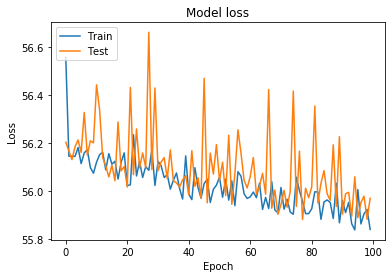

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [62]:
vae.metrics_names

['loss', 'kl_loss', 'recon_loss']

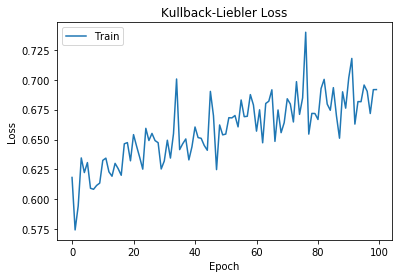

In [63]:
plt.plot(history.history['kl_loss'])
plt.title('Kullback-Liebler Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

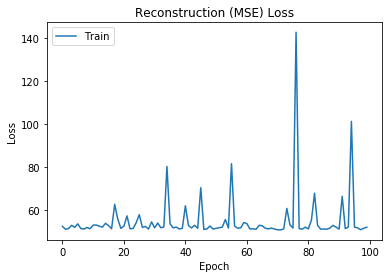

In [64]:
plt.plot(history.history['recon_loss'])
plt.title('Reconstruction (MSE) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [64]:
anom_df = csv_to_df('bsm_test/')

In [65]:
anom_df = anom_df.fillna(0)
anom_vars = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']
#Now we one_hot encode the data to make sure we have a class definition
anom_df = anom_df[['process_ID']+anom_vars]
anom_one_hot = pd.get_dummies(anom_df['process_ID'])
anom_processes = anom_one_hot.columns
anom_df.drop('process_ID', axis = 'columns', inplace = True)
anom_df = pd.concat([anom_df, anom_one_hot], sort = False, axis = 1)

In [69]:
#We have created a df of our values and some kind of class label
#We should normalize
anom_x = anom_df[anom_vars].values
anom_scaled = StandardScaler().fit_transform(anom_x)
anom_df[anom_vars] = anom_scaled

anom_x_train, anom_x_test, anom_y_train, anom_y_test = train_test_split(anom_df[anom_vars].values,
						    anom_df[anom_processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [70]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
anom_x_train = anom_x_train.reshape((anom_x_train.shape[0], 4, 3, 5))
anom_x_test = anom_x_test.reshape((anom_x_test.shape[0], 4, 3, 5))

In [73]:
from keras.models import load_model

In [93]:
vae.evaluate(x_train[:2455], anom_x_train)

2455/2455 [==============================] - 0s 149us/step


62.426984195748076